# First, Elegant to WarpX

In [1]:
import numpy as np
import h5py as h5
from matplotlib import rc
import scipy.constants as sc
import matplotlib.pyplot as plt
import makeopenpmd
import subprocess
import sys
import shutil
sys.path.insert(0, '/lstr/sahara/aard/cphillips/ipynbfiles/conversion')
import eleganttool2
import opal
import os

# Elegant optimization has to *end* at where we want to start the WarpX simulation

'''
Description of the layout of dist_piot.h5 input data

'data'
'0'
'particles'
   'myparticle'
      'position' (x,y,z), 'momentum' (x,y,z), 'charge' (idk)
everything else is empty, so might be unneeded?
'''

# install directories for PELEGANT and SDDS tools (should not be needed)
sddspath='/lstr/sahara/aard/philippe/codes/pelegant_metis/epics/extensions/bin/linux-x86_64/'
appspath='/lstr/sahara/aard/philippe/codes/pelegant_metis/oag/apps/bin/linux-x86_64/'

FontSize=16
          
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('xtick',labelsize=FontSize)
rc('ytick',labelsize=FontSize)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('font', size = FontSize)

mm = 1e3
cms = sc.speed_of_light

PWD=subprocess.run('pwd',stdout=subprocess.PIPE)
PWD.stdout

b'/lstr/sahara/aard/cphillips/ipynbfiles/conversion\n'

In [1]:
# output sdds with x, xp, y, yp, t, p, and particleID is %s.out
direc = '/lstr/sahara/aard/cphillips/1nC/1beam/2Ele/y42ch/'
direc = '/lstr/sahara/aard/cphillips/2nC/1beam/2Ele/y42ch/'
direc = '/lstr/sahara/aard/cphillips/5nC/1beam/2Ele/y42ch/'

basename = 'y42chopt'
h5outname = 'distWXin.h5'

sddsf = basename+'.wx'
xs = eleganttool2.import_numericaldata(direc+sddsf, column = 'x')
ys = eleganttool2.import_numericaldata(direc+sddsf, column = 'y')
ts = eleganttool2.import_numericaldata(direc+sddsf, column = 't')
zs = eleganttool2.import_numericaldata(direc+sddsf, column = 't')*sc.c

# Experimentally, let's add a .05 mm shift in x in the positive direction
#xs = xs+.001
xmean = np.mean(xs)
ymean = np.mean(ys)
xs = xs-xmean
ys = ys-ymean

# Need to recenter zs to 0 for warpx and make sure it's an array for makeopenpmd; also, flip the beam
zs = [-(z-np.average(zs)) for z in zs]
zs = np.array(zs)
#print(zs[:10])

# WARPX requires beta*gamma*m*c; Elegant is px/pz, py/pz, and np.sqrt(px^2+py^2+pz^2), so just multiply by m_e*c
pxz = eleganttool2.import_numericaldata(direc+sddsf, column = 'xp')
pyz = eleganttool2.import_numericaldata(direc+sddsf, column = 'yp')
pzz = eleganttool2.import_numericaldata(direc+sddsf, column = 'p')*sc.c*sc.m_e

pxz = pxz*pzz
pyz = pyz*pzz

# Also, need the charge
bunchCharge = eleganttool2.import_strdata(direc+sddsf, column = 'Charge')
print(-float(bunchCharge[0]))

# Finally, now we create the h5 WarpX input file
if os.path.isfile(direc+h5outname):
    os.remove(direc+h5outname)
makeopenpmd.make_openPMD(xs,ys,zs,pxz,pyz,pzz,direc+h5outname,-float(bunchCharge[0]))

NameError: name 'eleganttool2' is not defined

[ 0.49927041  0.34284793 -0.05622201  0.02158169  0.32426725  0.05922559
  0.11743539 -0.24694134  0.15651617 -0.16905794 -0.20390988 -0.07122962
 -0.35730355 -0.02517984 -0.24347863]
30000


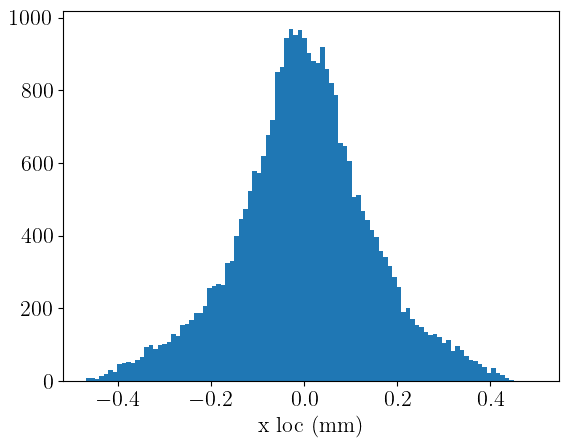

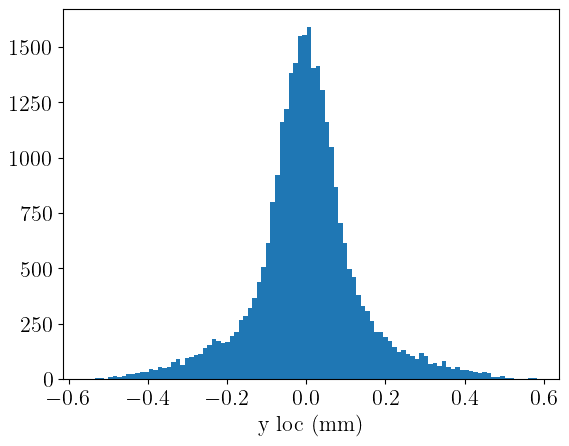

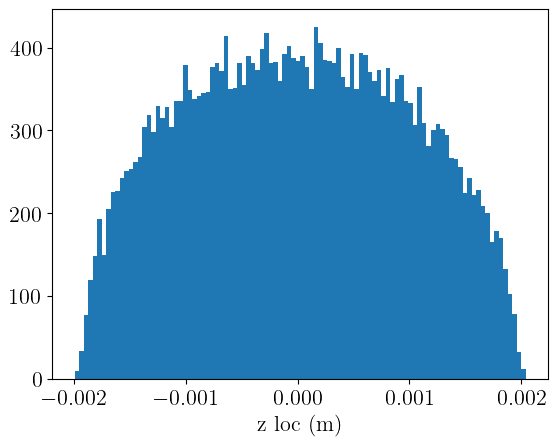

In [3]:
# Let's double check the data is actually written
fil = h5.File(direc+h5outname,'r')
dat = fil['data']
ts = dat['0']
par = ts['particles']
myp = par['myparticle']
pos = myp['position']
mom = myp['momentum']

xd = pos['x'][:]*1e3
yd = pos['y'][:]*1e3
zd = pos['z']
print(xd[:15])
print(len(xd))

px = mom['x']
py = mom['y']
pz = mom['z']

plt.hist(xd,bins=100)
plt.xlabel('x loc (mm)')
plt.show()
plt.hist(yd,bins=100)
plt.xlabel('y loc (mm)')
plt.show()
plt.hist(zd,bins=100)
plt.xlabel('z loc (m)')
plt.show()
#plt.hist(ts,bins=100)
#plt.show




### 2 Beam

In [2]:
'''
HAVE TO RUN ANALYSIS SCRIPT TO GET THE CORRECT SPLIT OUTPUT TO CREATE WARPX H5 INPUT FILE
'''
# output sdds with x, xp, y, yp, t, p, and particleID is %s.out
charge = '1nC'
#charge = '2nC'
#charge = '5nC'

#struct = 'circ/'
#struct = 'rect/'
struct = 'squa/'
struct = 'squa/scan/'

#struct = 'squaoptimize/'
#struct = 'threepfive/'

ts = 'ts9/'

direc = '/lstr/sahara/aard/cphillips/'+charge+'/2beam/2Ele/intowarpx/'
outdir = '/lstr/sahara/aard/cphillips/'+charge+'/2beam/3warpx/'

basenames = [struct+ts+'drive/y42chopt',struct+ts+'witness/lastrun/y42chopt']
h5outname = [struct+ts+'distWXin-b1.h5',struct+ts+'distWXin-b2.h5']
print(direc+basenames[0]+'.wx')
print(direc+basenames[1]+'.wx')

outt1 = eleganttool2.import_numericaldata(direc+basenames[0]+'.wx',column='t')
outt2 = eleganttool2.import_numericaldata(direc+basenames[1]+'.wx',column='t')
print(np.mean(outt2),np.mean(outt1))
tdiff = np.mean(outt2) - np.mean(outt1)
zdiff = tdiff*cms
#zdiff = -5.913936429905675e-3
print('Offset z (mm): ',zdiff*mm)

for i in np.arange(len(basenames)):
    sddsf = basenames[i]+'.wx'
    xs = eleganttool2.import_numericaldata(direc+sddsf, column = 'x')
    ys = eleganttool2.import_numericaldata(direc+sddsf, column = 'y')
    ts = eleganttool2.import_numericaldata(direc+sddsf, column = 't')
    zs = eleganttool2.import_numericaldata(direc+sddsf, column = 't')*sc.c

# Experimentally, let's add a .05 mm shift in x in the positive direction
#xs = xs+.001
    xmean = np.mean(xs)
    ymean = np.mean(ys)
    xs = xs-xmean
    ys = ys-ymean

# Need to recenter zs to 0 for warpx and make sure it's an array for makeopenpmd; also, flip the beam
    if i==0:
        zs = [-(z-np.average(zs)) for z in zs]
    elif i==1:
        zs = [(z-np.average(zs))+zdiff for z in zs]
    zs = np.array(zs)
#print(zs[:10])

# WARPX requires beta*gamma*m*c; Elegant is px/pz, py/pz, and np.sqrt(px^2+py^2+pz^2), so just multiply by m_e*c
    pxz = eleganttool2.import_numericaldata(direc+sddsf, column = 'xp')
    pyz = eleganttool2.import_numericaldata(direc+sddsf, column = 'yp')
    pzz = eleganttool2.import_numericaldata(direc+sddsf, column = 'p')*sc.c*sc.m_e
    
    pxz = pxz*pzz
    pyz = pyz*pzz

# Also, need the charge
    bunchCharge = eleganttool2.import_strdata(direc+sddsf, column = 'Charge')
    print(bunchCharge)

# Finally, now we create the h5 WarpX input file
    if os.path.isfile(direc+h5outname[i]):
        os.remove(direc+h5outname[i])
    makeopenpmd.make_openPMD(xs,ys,zs,pxz,pyz,pzz,h5outname[i],float(bunchCharge[0]))
    shutil.copyfile(h5outname[i],outdir+h5outname[i])

/lstr/sahara/aard/cphillips/1nC/2beam/2Ele/intowarpx/squa/scan/ts9/drive/y42chopt.wx
/lstr/sahara/aard/cphillips/1nC/2beam/2Ele/intowarpx/squa/scan/ts9/witness/lastrun/y42chopt.wx
6.655833803712283e-08 6.657800701628065e-08
Offset z (mm):  -5.896611608071991
['1.000000000000000e-09']
number of macroparticle: 30000
['1.000000000000000e-09']
number of macroparticle: 30000


squa/scan/ts9/distWXin-b1.h5
[-7.48843249e-04 -4.67176390e-04  8.47291565e-05 -4.32445749e-05
 -4.56344753e-04 -7.72213843e-05 -1.56326596e-04  3.35984088e-04
 -2.47209976e-04  2.50729872e-04  3.13850540e-04  1.53376600e-04
  4.90722698e-04  4.23502150e-05  3.59331012e-04]
30000


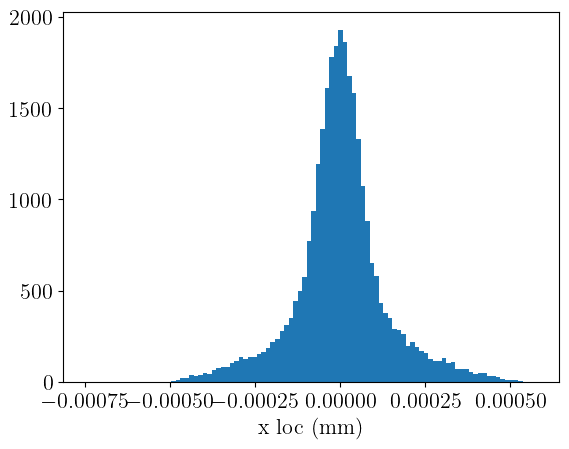

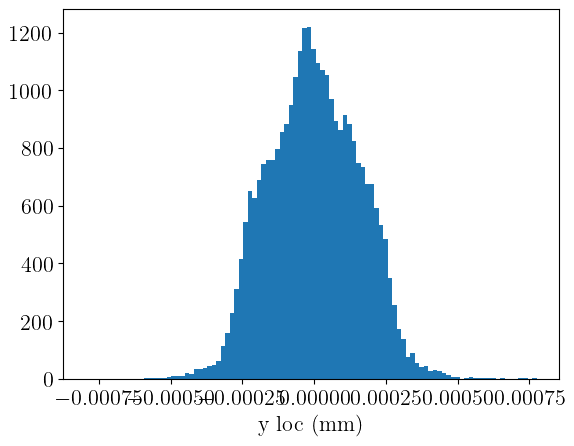

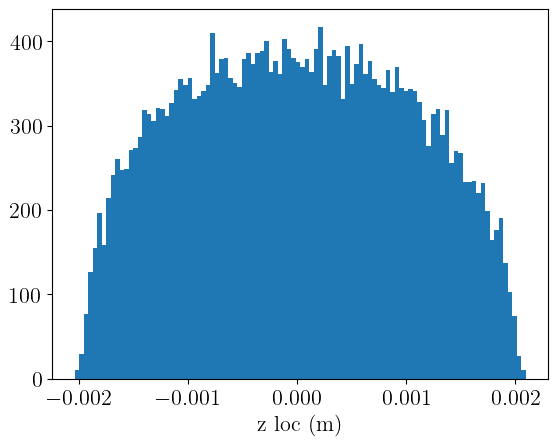

squa/scan/ts9/distWXin-b2.h5
[-6.09778984e-04 -3.61650804e-04  1.26031623e-04 -4.77716772e-05
 -4.25390983e-04 -1.54022836e-04 -1.46055277e-04  2.24257924e-04
 -1.05518254e-04  2.39864838e-04  2.63669931e-04 -1.89343549e-05
  3.48819640e-04  3.73535042e-05  3.11798934e-04]
30000


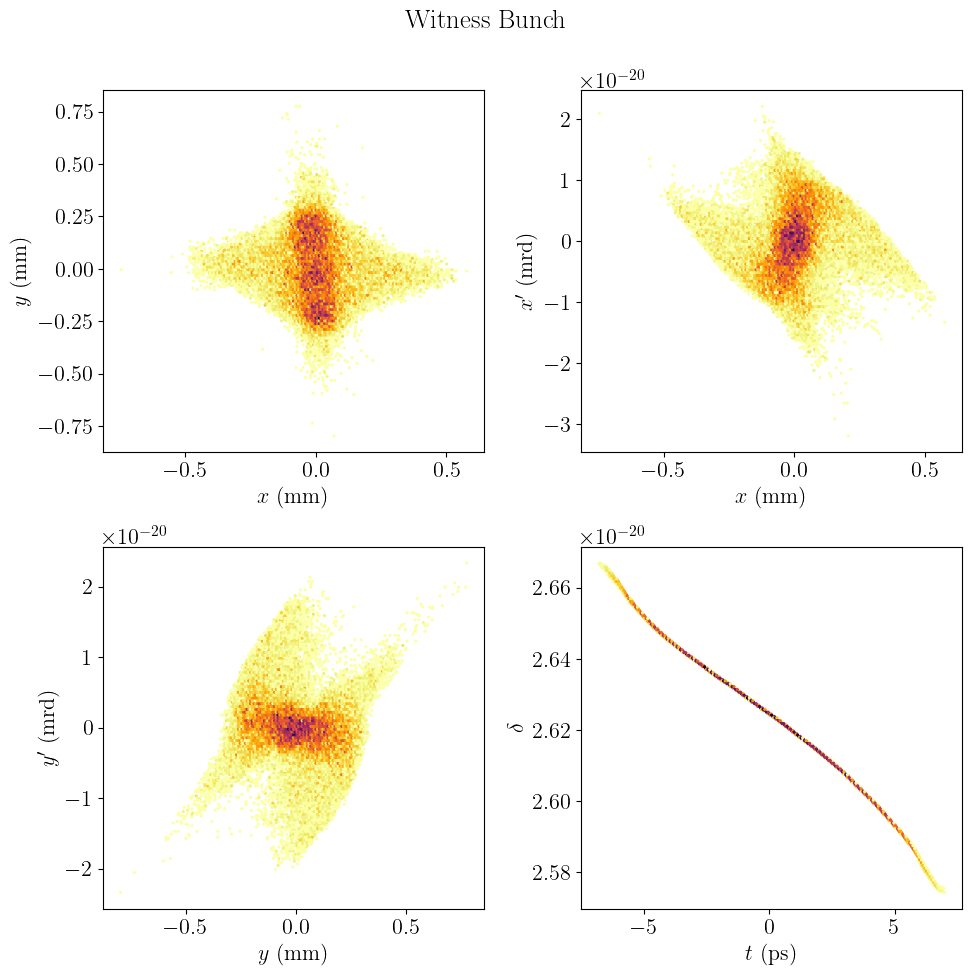

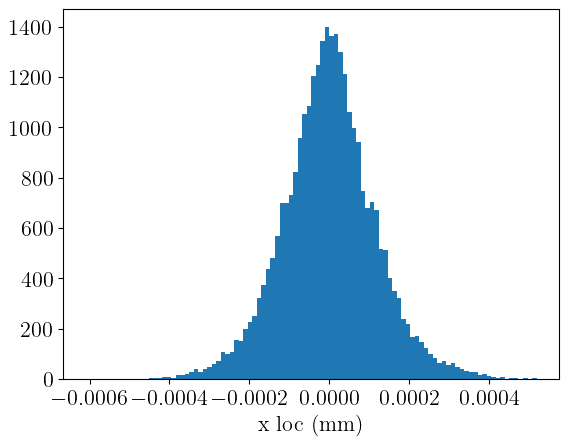

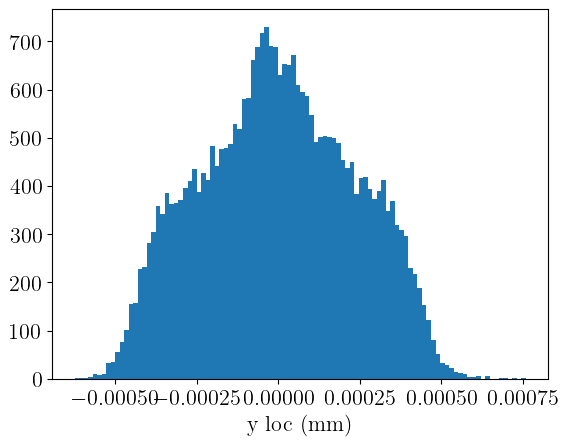

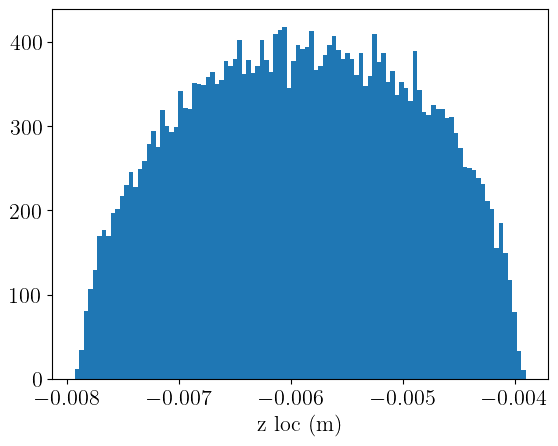

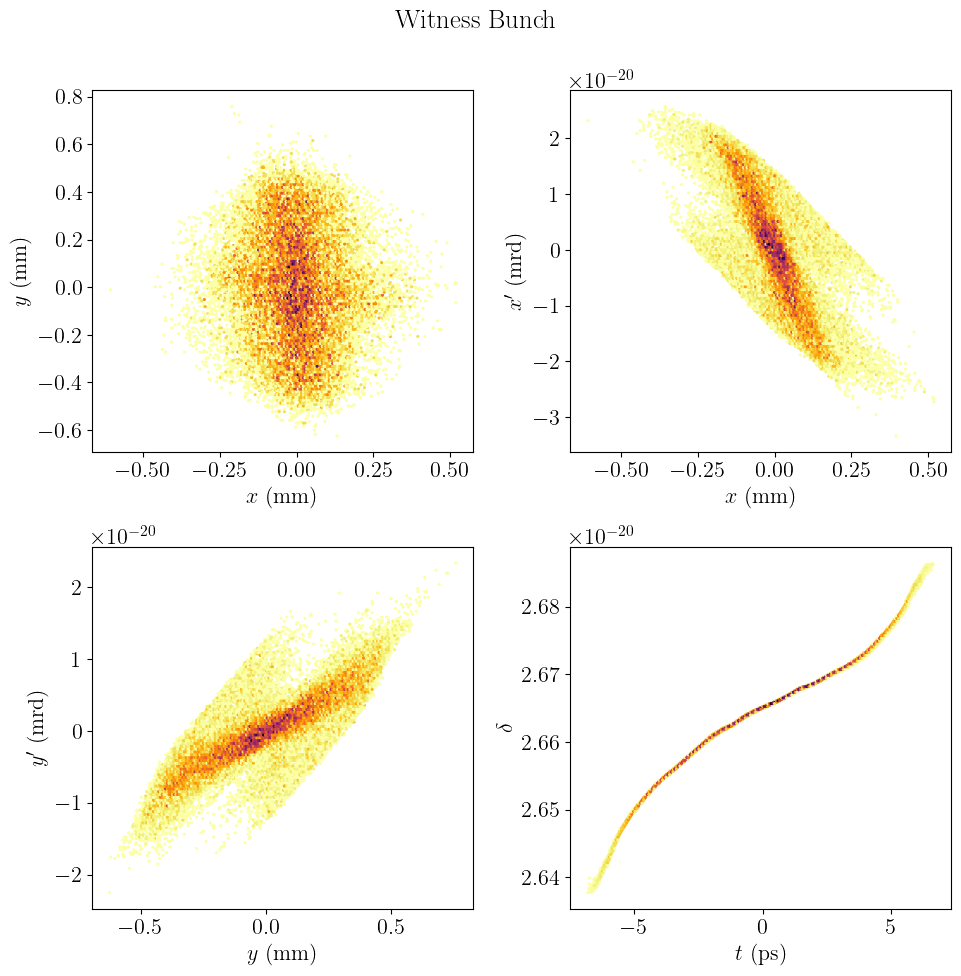

<Figure size 640x480 with 0 Axes>

In [3]:
nBins = 201
MinCnt = 1
# Let's double check the data is actually written
for i in np.arange(len(basenames)):
    fil = h5.File(outdir+h5outname[i],'r')
    print(h5outname[i])
    dat = fil['data']
    ts = dat['0']
    par = ts['particles']
    myp = par['myparticle']
    pos = myp['position']
    mom = myp['momentum']

    xd = pos['x'][:]
    yd = pos['y'][:]
    zd = pos['z'][:]
    ts = zd/cms
    tsps = [(ts[i]-np.mean(ts))*1e12 for i in np.arange(len(ts))]
    print(xd[:15])
    print(len(xd))

    px = mom['x'][:]
    py = mom['y'][:]
    pz = mom['z'][:]
    ptot = np.sqrt(px**2+py**2+pz**2)

    plt.hist(xd,bins=100)
    plt.xlabel('x loc (mm)')
    plt.show()
    plt.hist(yd,bins=100)
    plt.xlabel('y loc (mm)')
    plt.show()
    plt.hist(zd,bins=100)
    plt.xlabel('z loc (m)')
    plt.show()

    fig, axlist = plt.subplots(2,2,figsize=(10,10))
    ax = axlist[0,0]
    ax.hexbin(xd*1e3,yd*1e3,gridsize=nBins,mincnt=MinCnt, cmap='inferno_r')
    ax.set_xlabel('$x$ (mm)')
    ax.set_ylabel('$y$ (mm)')
    ax = axlist[0, 1]
    ax.set_xlabel('$x$ (mm)')
    ax.set_ylabel('$x\'$ (mrd)')
    ax.hexbin(xd*1e3, px*1e3, gridsize=nBins, mincnt=MinCnt, cmap='inferno_r')
    ax = axlist[1,0]
    ax.set_xlabel('$y$ (mm)')
    ax.set_ylabel('$y\'$ (mrd)')
    ax.hexbin(yd*1e3, py*1e3, gridsize=nBins, mincnt=MinCnt, cmap='inferno_r')
    ax = axlist[1,1]
    ax.hexbin(tsps, ptot, gridsize=nBins, mincnt=MinCnt, cmap='inferno_r')
    ax.set_xlabel('$t$ (ps)')
    ax.set_ylabel(r'$\delta$')
    plt.tight_layout()
    plt.suptitle('Witness Bunch')
    fig.subplots_adjust(top=0.9)
    plt.figure()
    
#plt.hist(ts,bins=100)
#plt.show




# Now, WarpX to Elegant

In [1]:
import numpy as np
import h5py as h5
from matplotlib import rc
import scipy.constants as sc
import makeopenpmd
import subprocess
import sys
sys.path.insert(0, '/lstr/sahara/aard/cphillips/ipynbfiles/conversion')
import eleganttool2
import opal

from openpmd_viewer import OpenPMDTimeSeries
from openpmd_viewer.addons import LpaDiagnostics

In [4]:
# Let's grab data from the warpx output; want the last data set
base = '/lstr/sahara/aard/cphillips/'

# 1 nC cases
direc = '1nC/1beam/3warpx/circ/14816_circ/' # 12
direc = '1nC/1beam/3warpx/rect/14961_1ncrect/' # 13
#direc = '1nC/1beam/3warpx/squa/14960_1ncsqua/'

# 2 nC cases
#direc = '2nC/1beam/3warpx/circ/14966_circ/' # 12
#direc = '2nC/1beam/3warpx/rect/14967_1ncrect/' # 13
#direc = '2nC/1beam/3warpx/squa/14965_1ncsqua/'

# 5 nC cases
#direc = '5nC/1beam/3warpx/circ/14968_circ/' # 12
#direc = '5nC/1beam/3warpx/rect/14969_1ncrect/' # 13
direc = '5nC/1beam/3warpx/squa/17188_1ncsqua/'
direc = '5nC/1beam/3warpx/nostruct/17411_1ncsqua/'

# Philippe cases
#direc = '1nC/philippe_dist/3warpx/circ/15332_circ/'
#direc = '1nC/philippe_dist/3warpx/rect/15331_1ncrect/'
#direc = '1nC/philippe_dist/3warpx/squa/15330_1ncsqua/'
#direc = '1nC/philippe_dist/2Ele/y42end/'

dist = base+direc+'diags/slabmovingwarpx/'
Nitera = -1

outname = 'distWXout_nb.sdds'


In [5]:
eleganttool2.dump_sdds(dist,Nitera,base+direc+outname)
## !!!!!! Still have to convert to binary if using Pelegant: 'sddsconvert -binary wx2LPS.sdds wxLPS.sdds'

writing ...
done.


In [6]:
# reading dist_piot to sdds file for ideal case
import h5py
base = '/lstr/sahara/aard/cphillips/1nC/philippe_dist/2Ele/y42end/'
h5file = base + 'dist_piot.h5'
outputname = base + 'dist_10cm.sdds'

f = h5py.File(h5file,'r')
dat = f['data']
ts0 = dat['0']
parts = ts0['particles']
myp = parts['myparticle']
pos = myp['position']
xf = pos['x'][:]
yf = pos['y'][:]
zf = pos['z'][:]
mom = myp['momentum']
px = mom['x'][:]
py = mom['y'][:]
pz = mom['z'][:]

tf = -zf/sc.c
numPart = len(xf)
id = np.arange(numPart)
A  = np.vstack((xf,px/pz,yf, py/pz, tf, np.sqrt(px**2+py**2+pz**2),id))
A[6,:]=A[6,:].astype('int')
f=open(outputname,'w')
f.write("SDDS1\n")
#        f.write("&parameter name=Step, description=\"Simulation step\", type=long, &end \n")
#        f.write("&parameter name=pCentral, symbol=\"p$bcen$n\", units=\"m$be$nc\", description=\"Reference beta*gamma\", type=double, &end\n")
#        f.write("&parameter name=Charge, units=C, description=\"Beam charge\", type=double, &end\n")
#        f.write("&parameter name=Particles, description=\"Number of particles\", type=long, &end\n")
f.write("&column name=x, units=m, type=double, &end \n")
f.write("&column name=xp, type=double,   &end \n")
f.write("&column name=y, units=m, type=double,  &end \n")
f.write("&column name=yp, type=double,  &end \n")
f.write("&column name=t, units=s, type=double,  &end \n")
f.write("&column name=p, type=double, units=\"m$be$nc\" &end \n")
f.write("&column name=particleID, type=long,  &end \n")
f.write("&data mode=ascii, &end \n")
f.write("! page number 1 \n") # this is the simulation step 
#        f.write(str(gamma_mean)+"\n") #  reference energy (bunch average)
#        f.write(str(qBunch)+"\n")
f.write(str(numPart)+"\n")
#        f.write(str(numPart)+"\n") # this is the number of lines
eleganttool2.writeT(f,A.T);
f.close()

writing ...
done.
